# (prototype) Relevance of time

This notebooks will try to assert the relevance of time in our predictions. That means, is the measured gap in 2017 relevant to the future of 2018? Will the schools located still be underrepresented in terms of SHSAT applicants?

How can we measure the influence of time though? We have SHSAT information for about 30 schools in Central Harlem, and this data ranges from 2013 to 2016. Fitting on this data, we can measure gaps of applicants. If the gaps in each school are correlated among the years, we assume that a prediction in one year is relevant to the next year.

To measure the strength of this correlation, though, we will use something. I believe the most useful metric would be the spearman correlation, as we are dealing with ranks of schools, and, if a school rank doesn't change among the years this is a good sign to PASSNYC (it can itervene in one year having data from another year).

I will have to research what PASSNYC will do with the data though to arrange the best correlation function. A safe method by now is plotting the correspondences between the years and calculating the pearsonr and spearman correlation!

## A note about the data

![](../data/keep/timeline.png)

Most of our data is related to the students that took SHSAT on 2017. Arranging to get data from other times is expensive and there is not much time right now. So, I will instead use just updated test scores data.

We can assume that most other characteristics are somewhat kept the same along the years. So, I will keep them the same.

*I will not be joining the SHSAT data from 2017 here, because  the baseline there is the # of students in HS admissions, while the baseline for D5 is the enrollment in October 31st*

In [149]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import parallel_coordinates
from scipy.special import expit, logit
from sklearn.decomposition import PCA
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold

pd.set_option('display.max_columns', None)


# bad
import warnings
warnings.filterwarnings("ignore")

In [56]:
centralharlem = pd.read_csv('../data/raw/D5 SHSAT Registrations and Testers.csv')
schools2017 = pd.read_pickle('../data/process/schools2017.pkl')

# drop 9th grade
centralharlem = centralharlem[centralharlem['Grade level'] == 8]
centralharlem = centralharlem.drop(['Grade level'], axis=1)

# rename columns
centralharlem = centralharlem.rename({
    'Year of SHST': 'Year'
}, axis=1)

In [57]:
found = sorted(set(centralharlem['DBN']) & set(schools2017.index))
notfound = sorted(set(centralharlem['DBN']) - set(schools2017.index))

print(len(found), "schools found")
print(len(notfound), "schools not found")

21 schools found
3 schools not found


3 schools missing

In [58]:
notfound

['05M367', '05M410', '05M469']

In [59]:
dir = pd.read_csv('../data/raw/middle_school_directory.csv')
dir.reindex(notfound)

,district,schooldbn,printedschoolname,overview,neighborhood,address,sharedbuilding,accessibility,telephone,independentwebsite,subway,bus,code_prog1,name_prog1,admissionsmethod_prog1,geapps_prog1,swdapps_prog1,geappsperseat_prog1,swdappsperseat_prog1,swdseats_prog1,geseats_prog1,gefilled_prog1,swdfilled_prog1,eligibility_prog1,priority1_prog1,priority2_prog1,priority3_prog1,priority4_prog1,priority5_prog1,priority6_prog1,priority7_prog1,prefnote_prog1,lowestpriority_prog1,selectioncriteria1_prog1,selectioncriteria2_prog1,selectioncriteria3_prog1,selectioncriteria4_prog1,selectioncriteria5_prog1,selectioncriteria6_prog1,selectioncriteria7_prog1,selectioncriteria8_prog1,selectioncriteria9_prog1,selectioncriteria10_prog1,selectioncriteria11_prog1,selectioncriteria12_prog1,revealed_prog1,code_prog2,name_prog2,admissionsmethod_prog2,geapps_prog2,swdapps_prog2,geappsperseat_prog2,swdappsperseat_prog2,swdseats_prog2,geseats_prog2,gefilled_prog2,swdfilled_prog2,eligibility_prog2,priority1_prog2,priority2_prog2,priority3_prog2,priority4_prog2,priority5_prog2,priority6_prog2,priority7_prog2,prefnote_prog2,lowestpriority_prog2,selectioncriteria1_prog2,selectioncriteria2_prog2,selectioncriteria3_prog2,selectioncriteria4_prog2,selectioncriteria5_prog2,selectioncriteria6_prog2,selectioncriteria7_prog2,selectioncriteria8_prog2,selectioncriteria9_prog2,selectioncriteria10_prog2,selectioncriteria11_prog2,selectioncriteria12_prog2,revealed_prog2,code_prog3,name_prog3,admissionsmethod_prog3,geapps_prog3,swdapps_prog3,geappsperseat_prog3,swdappsperseat_prog3,swdseats_prog3,geseats_prog3,gefilled_prog3,swdfilled_prog3,eligibility_prog3,priority1_prog3,priority2_prog3,priority3_prog3,priority4_prog3,priority5_prog3,priority6_prog3,priority7_prog3,prefnote_prog3,lowestpriority_prog3,selectioncriteria1_prog3,selectioncriteria2_prog3,selectioncriteria3_prog3,selectioncriteria4_prog3,selectioncriteria5_prog3,selectioncriteria6_prog3,selectioncriteria7_prog3,selectioncriteria8_prog3,selectioncriteria9_prog3,selectioncriteria10_prog3,selectioncriteria11_prog3,selectioncriteria12_prog3,revealed_prog3,code_prog4,name_prog4,admissionsmethod_prog4,geapps_prog4,swdapps_prog4,geappsperseat_prog4,swdappsperseat_prog4,swdseats_prog4,geseats_prog4,gefilled_prog4,swdfilled_prog4,eligibility_prog4,priority1_prog4,priority2_prog4,priority3_prog4,priority4_prog4,priority5_prog4,priority6_prog4,priority7_prog4,prefnote_prog4,lowestpriority_prog4,selectioncriteria1_prog4,selectioncriteria2_prog4,selectioncriteria3_prog4,selectioncriteria4_prog4,selectioncriteria5_prog4,selectioncriteria6_prog4,selectioncriteria7_prog4,selectioncriteria8_prog4,selectioncriteria9_prog4,selectioncriteria10_prog4,selectioncriteria11_prog4,selectioncriteria12_prog4,revealed_prog4,code_prog5,name_prog5,admissionsmethod_prog5,geapps_prog5,swdapps_prog5,geappsperseat_prog5,swdappsperseat_prog5,swdseats_prog5,geseats_prog5,gefilled_prog5,swdfilled_prog5,eligibility_prog5,priority1_prog5,priority2_prog5,priority3_prog5,priority4_prog5,priority5_prog5,priority6_prog5,priority7_prog5,prefnote_prog5,lowestpriority_prog5,selectioncriteria1_prog5,selectioncriteria2_prog5,selectioncriteria3_prog5,selectioncriteria4_prog5,selectioncriteria5_prog5,selectioncriteria6_prog5,selectioncriteria7_prog5,selectioncriteria8_prog5,selectioncriteria9_prog5,selectioncriteria10_prog5,selectioncriteria11_prog5,selectioncriteria12_prog5,revealed_prog5,code_prog6,name_prog6,admissionsmethod_prog6,geapps_prog6,swdapps_prog6,geappsperseat_prog6,swdappsperseat_prog6,swdseats_prog6,geseats_prog6,gefilled_prog6,swdfilled_prog6,eligibility_prog6,priority1_prog6,priority2_prog6,priority3_prog6,priority4_prog6,priority5_prog6,priority6_prog6,priority7_prog6,prefnote_prog6,lowestpriority_prog6,selectioncriteria1_prog6,selectioncriteria2_prog6,selectioncriteria3_prog6,selectioncriteria4_prog6,selectioncriteria5_prog6,selectioncriteria6_prog6,selectioncriteria7_prog6,selectioncriteria8_prog6,selectioncriteria9_prog6,selectioncrite

Were they closed?

In [60]:
centralharlem.set_index('DBN').loc[notfound].sort_values('Year')

,School name,Year,Enrollment on 10/31,Number of students who registered for the SHSAT,Number of students who took the SHSAT
DBN,,,,,
05M367,Academy for Social Action: A College Board School,2013,30,7,3
05M410,The Urban Assembly Institute for New Technologies,2013,43,1,0
05M469,Choir Academy of Harlem,2013,37,2,2
05M367,Academy for Social Action: A College Board School,2014,17,7,1
05M410,The Urban Assembly Institute for New Technologies,2014,26,4,3
05M469,Choir Academy of Harlem,2014,27,1,0
05M410,The Urban Assembly Institute for New Technologies,2015,40,18,9


No 2016 information leads me to believe they were closed... Okay!

## joining tests

In [61]:
tests = pd.read_pickle('../data/pre/test_results.pkl')
tests = tests.reset_index()
tests = tests[tests['Grade'] == 7].drop('Grade', axis=1)
tests = tests.set_index(['DBN', 'Year'])
tests.head()

Charter School?  Number Tested - ELA  Mean Scale Score - ELA  \
DBN    Year                                                                 
01M015 2013                0                  0.0                     NaN   
       2014                0                  0.0                     NaN   
       2015                0                  0.0                     NaN   
       2016                0                  0.0                     NaN   
       2017                0                  0.0                     NaN   

             # Level 1 - ELA  % Level 1 - ELA  # Level 2 - ELA  \
DBN    Year                                                      
01M015 2013              NaN              NaN              NaN   
       2014              NaN              NaN              NaN   
       2015              NaN              NaN              NaN   
       2016              NaN              NaN              NaN   
       2017              NaN              NaN              NaN   

             % Level 2 - ELA  # Level 3 - ELA  % Level 3 - ELA  \
DBN    Year                                                      
01M015 2013              NaN              NaN              NaN   
       2014              NaN              NaN              NaN   
       2015              NaN              NaN              NaN   
       2016              NaN              NaN              NaN   
       2017              NaN              NaN              NaN   

             # Level 4 - ELA  % Level 4 - ELA  # Level 3+4 - ELA  \
DBN    Year                                                        
01M015 2013              NaN              NaN                NaN   
       2014              NaN              NaN                NaN   
       2015              NaN              NaN                NaN   
       2016              NaN              NaN                NaN   
       2017              NaN              NaN                NaN   

             % Level 3+4 - ELA  Number Tested - Math  Mean Scale Score - Math  \
DBN    Year                                                                     
01M015 2013                NaN                   0.0                      NaN   
       2014                NaN                   0.0                      NaN   
       2015                NaN                   0.0                      NaN   
       2016                NaN                   0.0                      NaN   
       2017                NaN                   0.0                      NaN   

             # Level 1 - Math  % Level 1 - Math  # Level 2 - Math  \
DBN    Year                                                         
01M015 2013               NaN               NaN               NaN   
       2014               NaN               NaN               NaN   
       2015               NaN               NaN               NaN   
       2016               NaN               NaN               NaN   
       2017               NaN               NaN               NaN   

             % Level 2 - Math  # Level 3 - Math  % Level 3 - Math  \
DBN    Year                                                         
01M015 2013               NaN               NaN               NaN   
       2014               NaN               NaN               NaN   
       2015               NaN               NaN               NaN   
       2016               NaN               NaN               NaN   
       2017               NaN               NaN               NaN   

             # Level 4 - Math  % Level 4 - Math  # Level 3+4 - Math  \
DBN    Year                                                           
01M015 2013               NaN               NaN                 NaN   
       2014               NaN               NaN                 NaN   
       2015               NaN               NaN                 NaN   
       2016               NaN               NaN                 NaN   
       2017               NaN               NaN                 NaN   

             % Level 3+4 - Math  
DB

In [62]:
ch = centralharlem.copy()
ch = ch.set_index(['DBN', 'Year'])
ch.head()

School name  Enrollment on 10/31  \
DBN    Year                                                  
05M046 2013    P.S. 046 Arthur Tappan                   91   
       2014    P.S. 046 Arthur Tappan                   95   
       2015    P.S. 046 Arthur Tappan                   73   
       2016    P.S. 046 Arthur Tappan                   56   
05M123 2013  P.S. 123 Mahalia Jackson                   62   

             Number of students who registered for the SHSAT  \
DBN    Year                                                    
05M046 2013                                               31   
       2014                                               26   
       2015                                               21   
       2016                                               20   
05M123 2013                                               31   

             Number of students who took the SHSAT  
DBN    Year                                         
05M046 2013                                     14  
       2014                                      7  
       2015                                     10  
       2016                                      8  
05M123 2013                                     14

In [63]:
joined = ch.join(tests)
joined.head()

School name  Enrollment on 10/31  \
DBN    Year                                                  
05M046 2013    P.S. 046 Arthur Tappan                   91   
       2014    P.S. 046 Arthur Tappan                   95   
       2015    P.S. 046 Arthur Tappan                   73   
       2016    P.S. 046 Arthur Tappan                   56   
05M123 2013  P.S. 123 Mahalia Jackson                   62   

             Number of students who registered for the SHSAT  \
DBN    Year                                                    
05M046 2013                                               31   
       2014                                               26   
       2015                                               21   
       2016                                               20   
05M123 2013                                               31   

             Number of students who took the SHSAT  Charter School?  \
DBN    Year                                                           
05M046 2013                                     14              0.0   
       2014                                      7              0.0   
       2015                                     10              0.0   
       2016                                      8              0.0   
05M123 2013                                     14              0.0   

             Number Tested - ELA  Mean Scale Score - ELA  # Level 1 - ELA  \
DBN    Year                                                                 
05M046 2013                 84.0               -1.117422             47.0   
       2014                 85.0               -1.628713             57.0   
       2015                 66.0               -1.380656             41.0   
       2016                 58.0               -1.103425             39.0   
05M123 2013                 55.0               -1.045237             30.0   

             % Level 1 - ELA  # Level 2 - ELA  % Level 2 - ELA  \
DBN    Year                                                      
05M046 2013         55.95238             29.0         0.345238   
       2014         67.05882             22.0         0.258823   
       2015         62.12121             16.0         0.242424   
       2016         67.24138             14.0         0.241379   
05M123 2013         54.54545             20.0         0.363636   

             # Level 3 - ELA  % Level 3 - ELA  # Level 4 - ELA  \
DBN    Year                                                      
05M046 2013              7.0         0.083333              1.0   
       2014              6.0         0.070588              0.0   
       2015              9.0         0.136364              0.0   
       2016              2.0         0.034483              3.0   
05M123 2013              5.0         0.090909              0.0   

             % Level 4 - ELA  # Level 3+4 - ELA  % Level 3+4 - ELA  \
DBN    Year                                                          
05M046 2013         0.011905                8.0           9.523810   
       2014         0.000000                6.0           7.058824   
       2015         0.000000                9.0          13.636360   
       2016         0.051724                5.0           8.620690   
05M123 2013         0.000000                5.0           9.090909   

             Number Tested - Math  Mean Scale Score - Math  # Level 1 - Math  \
DBN    Year                                                                    
05M046 2013                  88.0                -0.744606              50.0   
       2014                  87.0                -1.012577              56.0   
       2015                  67.0                -0.977286              39.0   
       2016                  58.0                -1.679011              48.0   
05M123 2013                  61.0                -1.690491              47.0   

             % Level 1 - Math  # Level 2 - Math  % Level 2 - Math  \
DBN    Year                                              

### choosing columns

I will choose the columns to train on before joining with the alst dataset, to avoid messy conflicts.

In [64]:
schools2017 = schools2017[[
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Percent of Students Chronically Absent',
    'Economic Need Index',
]]

schools2017.head()

,Charter School?,Percent Asian,Percent Black,Percent Hispanic,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index
DBN,,,,,,,,,
01M034,0.0,0.053,0.297,0.614,0.006,0.080,0.380,0.305,0.872
01M140,0.0,0.044,0.121,0.794,0.011,0.124,0.338,0.395,0.853
01M184,0.0,0.697,0.044,0.124,0.050,0.171,0.192,0.041,0.560
01M188,0.0,0.019,0.320,0.625,0.000,0.154,0.332,0.369,0.938
01M301,0.0,0.087,0.323,0.496,0.039,0.047,0.441,0.382,0.746


In [65]:
joined = joined[[
    'Enrollment on 10/31',
    'Number of students who registered for the SHSAT',
    'Number of students who took the SHSAT',
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]]

joined.head()

Enrollment on 10/31  \
DBN    Year                        
05M046 2013                   91   
       2014                   95   
       2015                   73   
       2016                   56   
05M123 2013                   62   

             Number of students who registered for the SHSAT  \
DBN    Year                                                    
05M046 2013                                               31   
       2014                                               26   
       2015                                               21   
       2016                                               20   
05M123 2013                                               31   

             Number of students who took the SHSAT  Mean Scale Score - ELA  \
DBN    Year                                                                  
05M046 2013                                     14               -1.117422   
       2014                                      7               -1.628713   
       2015                                     10               -1.380656   
       2016                                      8               -1.103425   
05M123 2013                                     14               -1.045237   

             % Level 2 - ELA  % Level 3 - ELA  % Level 4 - ELA  \
DBN    Year                                                      
05M046 2013         0.345238         0.083333         0.011905   
       2014         0.258823         0.070588         0.000000   
       2015         0.242424         0.136364         0.000000   
       2016         0.241379         0.034483         0.051724   
05M123 2013         0.363636         0.090909         0.000000   

             Mean Scale Score - Math  % Level 2 - Math  % Level 3 - Math  \
DBN    Year                                                                
05M046 2013                -0.744606          0.352273          0.079545   
       2014                -1.012577          0.298851          0.057471   
       2015                -0.977286          0.343284          0.059701   
       2016                -1.679011          0.172414          0.000000   
05M123 2013                -1.690491          0.180328          0.049180   

             % Level 4 - Math  
DBN    Year                    
05M046 2013          0.000000  
       2014          0.000000  
       2015          0.014925  
       2016          0.000000  
05M123 2013          0.000000

### join

In [79]:
all = joined.join(schools2017, how='inner')  # drop schools that don't exist
pcts = all['Number of students who took the SHSAT'] / all['Enrollment on 10/31']
all = all[[
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]]
all = all.reset_index().set_index(['DBN', 'Year'])
all.head()

Charter School?  Percent Asian  Percent Black  Percent Hispanic  \
DBN    Year                                                                    
05M046 2013              0.0          0.006          0.472             0.502   
       2014              0.0          0.006          0.472             0.502   
       2015              0.0          0.006          0.472             0.502   
       2016              0.0          0.006          0.472             0.502   
05M123 2013              0.0          0.008          0.497             0.445   

             Percent Other  Percent English Language Learners  \
DBN    Year                                                     
05M046 2013          0.011                              0.104   
       2014          0.011                              0.104   
       2015          0.011                              0.104   
       2016          0.011                              0.104   
05M123 2013          0.011                              0.207   

             Percent Students with Disabilities  Economic Need Index  \
DBN    Year                                                            
05M046 2013                               0.300                0.897   
       2014                               0.300                0.897   
       2015                               0.300                0.897   
       2016                               0.300                0.897   
05M123 2013                               0.244                0.837   

             Mean Scale Score - ELA  % Level 2 - ELA  % Level 3 - ELA  \
DBN    Year                                                             
05M046 2013               -1.117422         0.345238         0.083333   
       2014               -1.628713         0.258823         0.070588   
       2015               -1.380656         0.242424         0.136364   
       2016               -1.103425         0.241379         0.034483   
05M123 2013               -1.045237         0.363636         0.090909   

             % Level 4 - ELA  Mean Scale Score - Math  % Level 2 - Math  \
DBN    Year                                                               
05M046 2013         0.011905                -0.744606          0.352273   
       2014         0.000000                -1.012577          0.298851   
       2015         0.000000                -0.977286          0.343284   
       2016         0.051724                -1.679011          0.172414   
05M123 2013         0.000000                -1.690491          0.180328   

             % Level 3 - Math  % Level 4 - Math  
DBN    Year                                      
05M046 2013          0.079545          0.000000  
       2014          0.057471          0.000000  
       2015          0.059701          0.014925  
       2016          0.000000          0.000000  
05M123 2013          0.049180          0.000000

In [88]:
# create a dummy year variable

years = all.reset_index()['Year']
dummies = pd.get_dummies(years).drop(2016, axis=1)  # drop to avoid total collinearity
dummies.index = all.index
inputs = pd.concat([
    all,
    dummies
], axis=1)
inputs.head()

Charter School?  Percent Asian  Percent Black  Percent Hispanic  \
DBN    Year                                                                    
05M046 2013              0.0          0.006          0.472             0.502   
       2014              0.0          0.006          0.472             0.502   
       2015              0.0          0.006          0.472             0.502   
       2016              0.0          0.006          0.472             0.502   
05M123 2013              0.0          0.008          0.497             0.445   

             Percent Other  Percent English Language Learners  \
DBN    Year                                                     
05M046 2013          0.011                              0.104   
       2014          0.011                              0.104   
       2015          0.011                              0.104   
       2016          0.011                              0.104   
05M123 2013          0.011                              0.207   

             Percent Students with Disabilities  Economic Need Index  \
DBN    Year                                                            
05M046 2013                               0.300                0.897   
       2014                               0.300                0.897   
       2015                               0.300                0.897   
       2016                               0.300                0.897   
05M123 2013                               0.244                0.837   

             Mean Scale Score - ELA  % Level 2 - ELA  % Level 3 - ELA  \
DBN    Year                                                             
05M046 2013               -1.117422         0.345238         0.083333   
       2014               -1.628713         0.258823         0.070588   
       2015               -1.380656         0.242424         0.136364   
       2016               -1.103425         0.241379         0.034483   
05M123 2013               -1.045237         0.363636         0.090909   

             % Level 4 - ELA  Mean Scale Score - Math  % Level 2 - Math  \
DBN    Year                                                               
05M046 2013         0.011905                -0.744606          0.352273   
       2014         0.000000                -1.012577          0.298851   
       2015         0.000000                -0.977286          0.343284   
       2016         0.051724                -1.679011          0.172414   
05M123 2013         0.000000                -1.690491          0.180328   

             % Level 3 - Math  % Level 4 - Math  2013  2014  2015  
DBN    Year                                                        
05M046 2013          0.079545          0.000000     1     0     0  
       2014          0.057471          0.000000     0     1     0  
       2015          0.059701          0.014925     0     0     1  
       2016          0.000000          0.000000     0     0     0  
05M123 2013          0.049180          0.000000     1     0     0

In [90]:
outputs = logit(pcts)
outputs.head()

DBN     Year
05M046  2013   -1.704748
        2014   -2.531427
        2015   -1.840550
        2016   -1.791759
05M123  2013   -1.232144
dtype: float64

# Cross-validate

In [121]:
# cross-validation
cv_results = []
n_splits = 10
n_repeats = 20
for n_components in range(1, inputs.shape[1] + 1):
    mae_scores = []
    mse_scores = []
    
    x = PCA(n_components).fit_transform(inputs)
    x = pd.DataFrame(x, index=inputs.index, columns=["PC{}".format(i) for i in range(1, n_components + 1)])
    x['Constant'] = 1
    y = outputs.copy()
    

    cv = RepeatedKFold(n_splits, n_repeats, random_state=1)    
    for train, test in cv.split(x):
        x_train = x.iloc[train]
        x_test = x.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        
        model = sm.RLM(y_train, x_train, M=sm.robust.norms.HuberT())
        results = model.fit()
        predictions = model.predict(results.params, exog=x_test)
        mae = median_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        mae_scores.append(mae)
        mse_scores.append(mse)
        
    mae_scores = np.array(mae_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
    mse_scores = np.array(mse_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
        
    mae_mean = np.mean(mae_scores)
    mae_std = np.std(mae_scores)
    mse_mean = np.mean(mse_scores)
    mse_std = np.std(mse_scores)
    
    cv_result = (n_components, mae_mean, mse_mean, mae_std, mse_std)
    cv_results.append(cv_result)
    
df_columns = ['n_components', 'mae__mean', 'mse__mean', 'mae__std', 'mse__std']
cv_results_df = pd.DataFrame(cv_results, columns=df_columns)
cv_results_df

,n_components,mae__mean,mse__mean,mae__std,mse__std
0,1,0.391367,0.342193,0.021451,0.006582
1,2,0.395973,0.347532,0.023967,0.006935
2,3,0.401132,0.353792,0.025005,0.007007
3,4,0.397428,0.363116,0.023860,0.009225
4,5,0.404037,0.365935,0.025856,0.013343
5,6,0.414245,0.378384,0.030261,0.014267
6,7,0.419936,0.392630,0.031364,0.014195
7,8,0.404284,0.371987,0.031148,0.012073
8,9,0.412473,0.398063,0.027250,0.015926
9,10,0.417367,0.413170,0.024830,0.014069


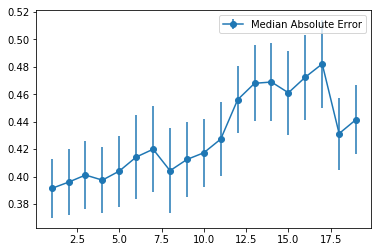

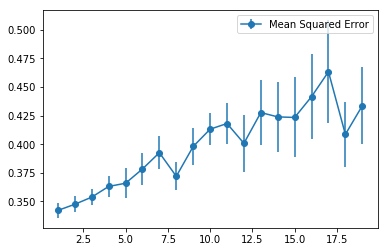

In [122]:
# visualize results

cvdf = cv_results_df  # code sugar

plt.figure()
plt.errorbar(cvdf.n_components, cvdf.mae__mean, cvdf.mae__std, marker='o', label='Median Absolute Error')
plt.legend()

plt.figure()
plt.errorbar(cvdf.n_components, cvdf.mse__mean, cvdf.mse__std, marker='o', label='Mean Squared Error')
plt.legend();

# Model

In [130]:
pcs = pd.DataFrame(PCA(1).fit_transform(inputs), index=inputs.index, columns=['PC1'])

model = HuberRegressor(epsilon=1)
model.fit(pcs, outputs)
predictions = model.predict(pcs)
residuals = outputs - predictions
pct_residuals = expit(outputs) - expit(predictions)

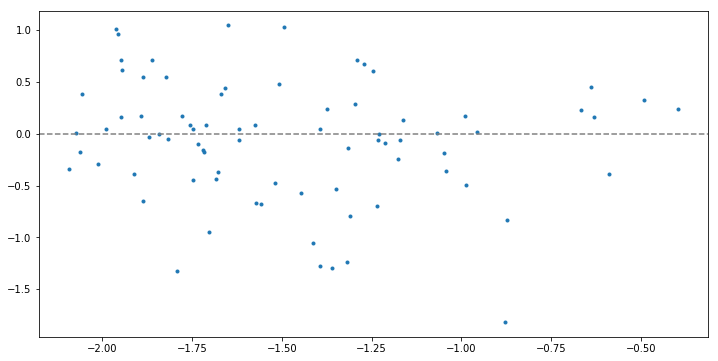

In [131]:
plt.figure(figsize=(12, 6))
plt.plot(predictions, residuals, '.')
plt.axhline(0, linestyle='--', color='gray')

In [132]:
comparisons = pd.Series(pct_residuals, index=inputs.index)
comparisons.name = 'Estimated Gap'
comparisons = comparisons.reset_index()
comparisons.head()

,DBN,Year,Estimated Gap
0,05M046,2013,0.005480
1,05M046,2014,-0.058128
2,05M046,2015,0.000005
3,05M046,2016,0.018089
4,05M123,2013,0.100780


In [134]:
pivoted = comparisons.pivot_table(index='DBN', columns='Year', values='Estimated Gap')
pivoted.head()

Year,2013,2014,2015,2016
DBN,,,,
05M046,0.005480,-0.058128,0.000005,0.018089
05M123,0.100780,0.084439,-0.029269,-0.037857
05M129,0.022021,0.079085,0.011363,0.105307
05M148,NaN,NaN,-0.088285,-0.048535
05M161,-0.100425,-0.011912,0.011899,-0.075452


In [136]:
pivoted.corr(method='pearson')

Year,2013,2014,2015,2016
Year,,,,
2013,1.000000,0.691385,0.350787,0.402521
2014,0.691385,1.000000,0.333686,0.398028
2015,0.350787,0.333686,1.000000,0.478753
2016,0.402521,0.398028,0.478753,1.000000


In [137]:
pivoted.corr(method='spearman')

Year,2013,2014,2015,2016
Year,,,,
2013,1.000000,0.754386,0.110423,0.428277
2014,0.754386,1.000000,0.191228,0.436842
2015,0.110423,0.191228,1.000000,0.544361
2016,0.428277,0.436842,0.544361,1.000000


Okay... This looks like a bad knife. I need a better explanation of what correlations mean.

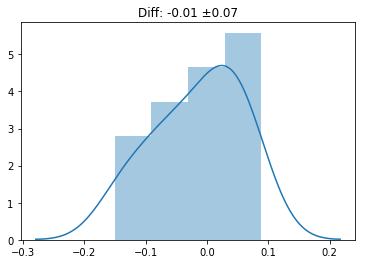

In [153]:
diffs = (pivoted[2014] - pivoted[2013]).dropna()
mean = diffs.mean()
std = diffs.std()

sns.distplot(diffs, ax=ax2)
ax2.set_title("Diff: {:.2f} ±{:.2f}".format(mean, std))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot([-0.2, 0.2], [-0.2, 0.2], '--', color='gray')
ax1.plot(pivoted[2013], pivoted[2014], '.')
ax1.set_xlabel("Estimated Gap in 2013")
ax1.set_ylabel("Estimated Gap in 2014")
ax1.set_xlim(-0.2, 0.2)
ax1.set_ylim(-0.2, 0.2)
ax2

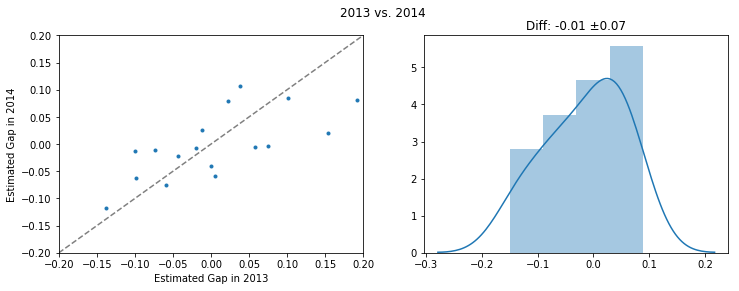

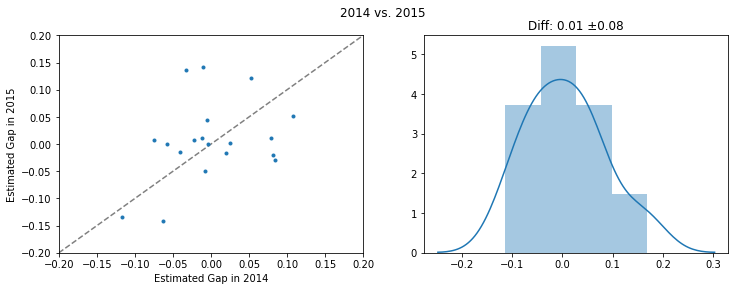

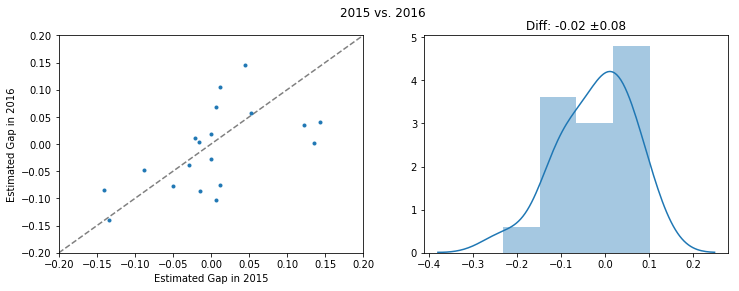

In [158]:
combinations = [
    (2013, 2014),
    (2014, 2015),
    (2015, 2016),
]

for y1, y2 in combinations:
    diffs = (pivoted[y2] - pivoted[y1]).dropna()
    mean = diffs.mean()
    std = diffs.std()
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
    fig.suptitle("%s vs. %s" % (y1, y2))

    ax1.plot([-0.2, 0.2], [-0.2, 0.2], '--', color='gray')
    ax1.plot(pivoted[y1], pivoted[y2], '.')
    ax1.set_xlabel("Estimated Gap in %s" % y1)
    ax1.set_ylabel("Estimated Gap in %s" % y2)
    ax1.set_xlim(-0.2, 0.2)
    ax1.set_ylim(-0.2, 0.2)

    sns.distplot(diffs, ax=ax2)
    ax2.set_title("Diff: {:.2f} ±{:.2f}".format(mean, std))